In [60]:
import h5py
import numpy as np
import scipy.signal as sps
import matplotlib.pyplot as plt

In [61]:
def read_ligo(filename):
    f = h5py.File(filename, 'r')
    strain = f['strain']['Strain'][...]
    fs = 1/ f['strain']['Strain'].attrs['Xspacing']
    f.close()
    return strain, fs

In [65]:
# Open hdf5 files
h1_32, fs_h1_32 = read_ligo('../../assets/data/h1_32sec_4khz.hdf5')
l1_32, fs_l1_32 = read_ligo('../../assets/data/l1_32sec_4khz.hdf5')

fs = fs_h1_32
print(fs)
NFFT = 4*fs
fband = [43.0, 300.0]

4096.0


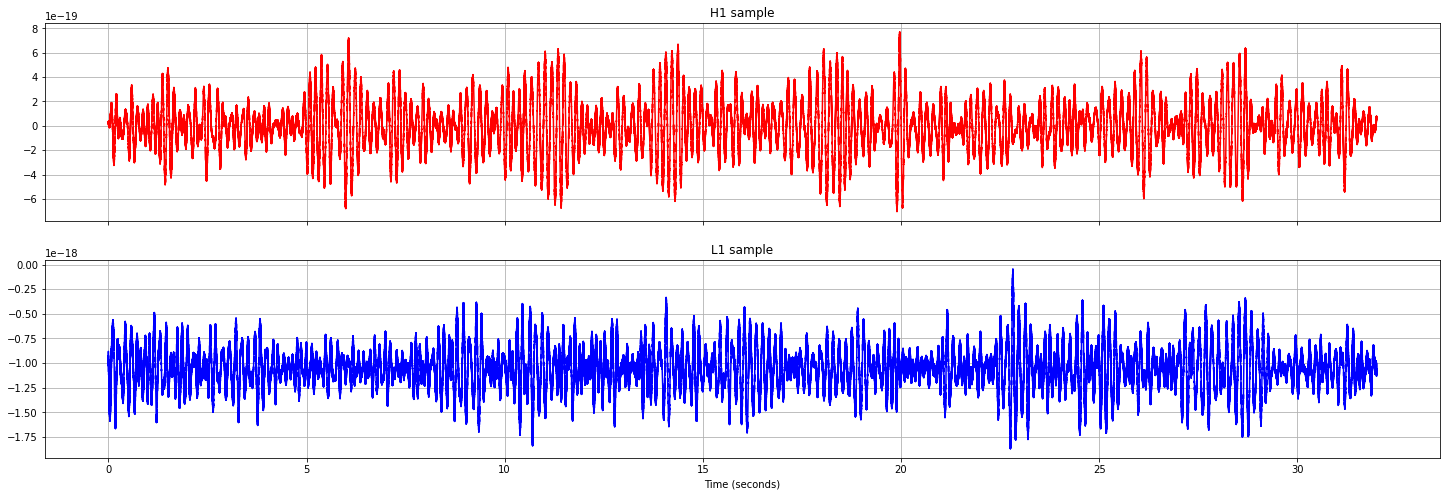

In [63]:
# Plot signals
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
axs[0].plot(np.arange(0,h1_32.shape[0]/fs_h1_32, 1/fs_h1_32), h1_32, color='red')
axs[1].plot(np.arange(0,l1_32.shape[0]/fs_l1_32, 1/fs_l1_32), l1_32, color='blue')
axs[0].set_title('H1 sample')
axs[1].set_title('L1 sample')
axs[1].set_xlabel('Time (seconds)')
axs[0].grid()
axs[1].grid()

In [67]:
import matplotlib.mlab as mlab
Pxx_H1, freqs = mlab.psd(h1_32, Fs = int(fs), NFFT = int(NFFT))
psd_H1 = interp1d(freqs, Pxx_H1)

In [72]:
import numpy as np
from scipy import signal as sig

def periodogram_averaging(data, K, L):
    if data is None or data is np.empty:
        raise ValueError("Data array doesn't exist.")
    #Check parameters
    data_array = np.array(data)
    N = len(data_array)

    if K<=0:
        raise ValueError("K must be positive.")

    if L<=0:
        raise ValueError("L must be positive.")

    if K>N:
        raise ValueError("Sample amount (N) must be greater or equal to segments amount (K)")

    if L>N:
        raise ValueError("Invalid. Data array's size must be greater or equal to segment's size (L).")

    #Create periodograms
    D = int(round(N/K))

    # Add padding due to overlap
    padding_to_add = D*(K-1)+L - N

    if padding_to_add<0:
        raise ValueError("Invalid segment amount or size.")

    padding_beginning = int(padding_to_add/2)
    data_array = np.pad(data_array, (padding_beginning, padding_to_add - padding_beginning), 'edge')

    periodograms = []
    for i in range(K):
        data_i = data_array[D*i:D*i+L]
        f_i, p_i = sig.periodogram(data_i, window='hann')
        periodograms.append(np.array(p_i))
    
    #Average periodograms
    avg_periodogram = np.mean(np.array(periodograms), axis=0)

    return f_i, avg_periodogram



In [94]:
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt
import numpy as np
import matplotlib.pyplot as plt

# # both H1 and L1 will have the same time vector, so:
# time = fs_h1_32
# # the time sample interval (uniformly sampled!)
# dt = time[1] - time[0]

# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    freqs1 = np.linspace(0,2048.,int(Nt/2+1))

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return  white_ht
 
def filter(whitened_signal, fs, fband):
    # We need to suppress the high frequency noise (no signal!) with some bandpassing:
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
    return filtfilt(bb, ab, whitened_signal) / normalization

print(len(h1_32))

# L2 = 1
# K2 = 131072

# Pxx_H1, freqs_0a1 = periodogram_averaging(h1_32, K2, L2)

# freqs = freqs_0a1*fs



print(len(freqs))
print(len(Pxx_H1))

psd_H1 = interp1d(freqs, Pxx_H1)

strain_H1_whiten = whiten(h1_32, psd_H1, 1./fs)
strain_H1_whitenbp = filter(strain_H1_whiten, fs, fband)


131072
1
1


ValueError: x and y arrays must have at least 2 entries

In [ ]:
L2 = 700
K2 = 800


Pxx_H1, freqs_0a1 = periodogram_averaging(h1_32, K2, L2)

freqs = freqs_0a1*fs

print(freqs)

plt.plot(freqs, Pxx_H1, color = 'red', label = 'whitening')
plt.legend()
plt.title('whitening')
plt.grid()
plt.show()


psd_H1 = interp1d(freqs, Pxx_H1)
freqss, strain_H1_whiten = whiten(h1_32, psd_H1, 2)

frequencies = np.linspace(0, 131072,131072)
print(len(strain_H1_whiten))


plt.plot(freqs, strain_H1_whiten, color = 'red', label = 'whitening')
plt.legend()
plt.title('whitening')
plt.grid()
plt.show()



plt.plot(freqs, strain_H1_whitenbp, color = 'red', label = 'whitening')
plt.legend()
plt.title('whitening')
plt.grid()
plt.show()